In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

%matplotlib inline

In [2]:
osha = pd.read_csv('../data/osha/osha_norm_naics.csv', dtype={'naics_code':str, 'sic_code':str},
                  na_values = ["", " ","NaN", "nan", "NA", "na", "Na"])
osha = osha[['inspection_number', 'establishment_name', 'preferred_name','naics_unified', 'sector_name', 'subsector_name',
             'industry_group_name', 'conc_mgm3']]  # keep only cols we need
osha = osha[~osha['sector_name'].isin(["Undefined/Multiple"])]
osha = osha.drop(osha[osha['conc_mgm3']>10000].index)
#osha = osha.drop(osha[osha['qualifier'].str.contains('BLK', na=False)].index)  # drop blanks
#osha['conc_mgm3'] = np.where(osha['qualifier'].str.contains('ND',na=False), 0, osha['conc_mgm3'])  # if non-detect, set conc to 0
osha['log_conc'] = np.log(osha['conc_mgm3']+0.0001)
osha['log_conc2'] = np.log(osha['conc_mgm3']+0.00000000001)
osha = osha.dropna(subset=['conc_mgm3', 'log_conc','sector_name'])
osha['sector_enc'] = osha['sector_name'].astype('category').cat.codes
osha['subsector_enc'] = osha['subsector_name'].astype('category').cat.codes
osha['industry_group_enc'] = osha['industry_group_name'].astype('category').cat.codes


/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,7,11,20,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
osha = osha.groupby(['inspection_number', 'establishment_name', 'preferred_name','naics_unified', 'sector_name',
                     'subsector_name', 'industry_group_name', 'sector_enc', 'subsector_enc', 'industry_group_enc'], as_index=False).max()
osha.head(10)

,inspection_number,establishment_name,preferred_name,naics_unified,sector_name,subsector_name,industry_group_name,sector_enc,subsector_enc,industry_group_enc,conc_mgm3,log_conc,log_conc2
0,29067,"GARMAT USA, INC.",Iron oxide,332322,Manufacturing,Fabricated Metal Product Manufacturing,Architectural and Structural Metals Manufacturing,10,26,18,1.959734,0.672860,0.672809
1,29206,Polar Corporation,Iron oxide,811310,Other Services,Repair and Maintenance,Commercial and Industrial Machinery and Equipm...,12,76,49,12.966245,2.562357,2.562349
2,29251,"Jobsite, Inc.",Iron oxide,333517,Manufacturing,Machinery Manufacturing,Metalworking Machinery Manufacturing,10,44,150,0.519814,-0.654091,-0.654284
3,29479,"TIC, The Industrial Company",Iron oxide,236210,Construction,Construction of Buildings,Nonresidential Building Construction,4,17,167,0.080790,-2.514664,-2.515901
4,63156,Nomad Global Communication Solutions,Iron oxide,334290,Manufacturing,Computer and Electronic Product Manufacturing,Communications Equipment Manufacturing,10,16,52,3.093908,1.129467,1.129435
5,63259,"PRECISION PLATING COMPANY, INC.",Iron oxide,332813,Manufacturing,Fabricated Metal Product Manufacturing,"Coating, Engraving, Heat Treating, and Allied ...",10,26,47,0.000000,-9.210340,-25.328436
6,76901,USDOL OSHA - TOLEDO,Iron oxide,926150,Public Administration,Administration of Economic Programs,Administration of Economic Programs,14,1,2,0.076289,-2.571911,-2.573221
7,77033,"Velcon Filters, LLC",Iron oxide,333999,Manufacturing,Machinery Manufacturing,Other General Purpose Machinery Manufacturing,10,44,189,0.000000,-9.210340,-25.328436
8,77128,"LINDGREN RF ENCLOSURES, INC.",Iron oxide,332321,Manufacturing,Fabricated Metal Product Manufacturing,Architectural and Structural Metals Manufacturing,10,26,18,0.290482,-1.235868,-1.236212
9,77282,NISSAN FORKLIFT CORP.,Iron oxide,333924,Manufacturing,Machinery Manufacturing,Other General Purpose Machinery Manufacturing,10,44,189,7.120376,1.962975,1.962961


In [4]:
len(osha)

233975

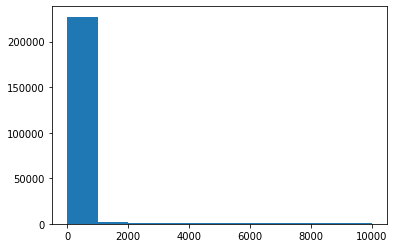

In [5]:
osha['conc_mgm3'].hist(grid=False)
plt.show()

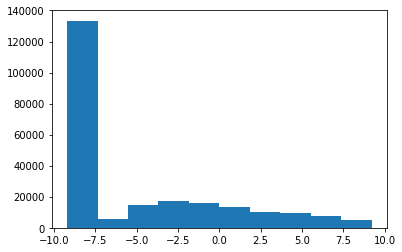

In [6]:
osha['log_conc'].hist(grid=False)
plt.show()

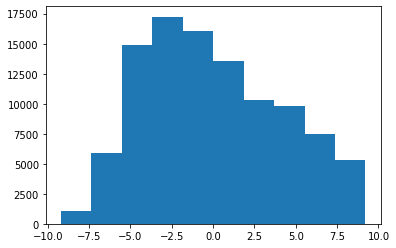

In [7]:
osha[osha.conc_mgm3 > 0]['log_conc'].hist(grid=False)
plt.show()

In [8]:
osha['conc_mgm3'].isnull().values.any()

False

In [9]:
osha['sector_name'].nunique()

20

In [10]:
osha_nz = osha[osha.conc_mgm3 > 0].copy()  # make dataset for nonzero entries
osha_nz['sector_enc'] = osha_nz['sector_name'].astype('category').cat.codes  # re-encode 
osha_nz['subsector_enc'] = osha_nz['subsector_name'].astype('category').cat.codes  # re-encode

## OSHA data coverage across industry sectors 

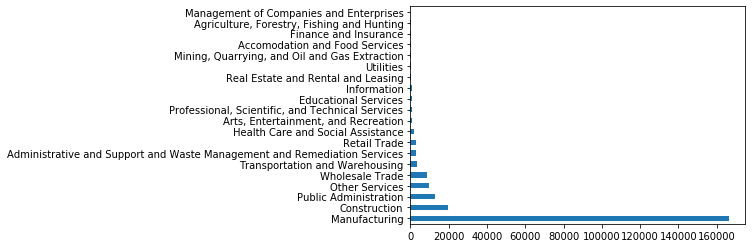

In [11]:
sector_counts = osha.sector_name.value_counts()
sector_counts.plot(kind='barh')

In [12]:
sector_counts

Manufacturing                                                               166618
Construction                                                                 19597
Public Administration                                                        12773
Other Services                                                                9498
Wholesale Trade                                                               8442
Transportation and Warehousing                                                3649
Administrative and Support and Waste Management and Remediation Services      3117
Retail Trade                                                                  3113
Health Care and Social Assistance                                             1943
Arts, Entertainment, and Recreation                                           1015
Professional, Scientific, and Technical Services                               997
Educational Services                                                           625
Info

## OSHA data coverage across industry subsectors and groups

#### Looking at subectors (n=98):

In [13]:
subsector_counts = osha.subsector_name.value_counts() 
subsector_counts

Fabricated Metal Product Manufacturing                                  36144
Undefined/Multiple                                                      33145
Primary Metal Manufacturing                                             30090
Transportation Equipment Manufacturing                                  15752
Machinery Manufacturing                                                 13336
                                                                        ...  
Lessors of Nonfinancial Intangible Assets (except Copyrighted Works)        8
Other Information Services                                                  8
Pipeline Transportation                                                     7
Funds, Trusts, and Other Financial Vehicles                                 6
Fishing, Hunting and Trapping                                               1
Name: subsector_name, Length: 98, dtype: int64

#### How many subsectors have over 25 inspections?

In [14]:
sum(subsector_counts > 25)

83

#### Looking at industry groups (n=298):

In [15]:
group_counts = osha.industry_group_name.value_counts() 
group_counts

Undefined/Multiple                                          50371
Foundries                                                   18792
Architectural and Structural Metals Manufacturing           11373
Administration of Economic Programs                         10317
Coating, Engraving, Heat Treating, and Allied Activities     8331
                                                            ...  
RV (Recreational Vehicle) Parks and Recreational Camps          2
Vending Machine Operators                                       1
Apparel Knitting Mills                                          1
Pipeline Transportation of Natural Gas                          1
Fishing                                                         1
Name: industry_group_name, Length: 298, dtype: int64

#### How many industry groups have over 25 inspections?

In [16]:
sum(group_counts > 25)

203

## A simple hierarchical model ignoring sampling bias and detection limits

In [17]:
len(osha), len(osha_nz)

(233975, 101630)

### Non-zero hierarchical model

In [18]:
with pm.Model() as hierarchical_osha:
    
    global_mu = pm.Normal('global_mu', sd=2)
    prior_sigma = pm.Exponential('prior_sigma', lam=5.)
    mu = pm.Normal("mu", mu=global_mu, sd=prior_sigma, shape=(21,))
    
    prior_lam = pm.Exponential('prior_lam', lam=1.)
    sigma = pm.Exponential("sigma", lam=prior_lam, shape=(21,))
    
    like = pm.Normal(
        'likelihood',
        mu=mu[osha_nz['sector_enc']],
        sd=sigma[osha_nz['sector_enc']],
        observed=osha_nz['log_conc'],
        total_size = len(osha_nz)
    )

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [19]:
with hierarchical_osha:
    mean_field = pm.fit(20000, method='ADVI', callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])

  0%|          | 0/20000 [00:00<?, ?it/s]/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Average Loss = 2.885e+05:  62%|██████▏   | 12365/20000 [04:04<02:30, 50.61it/s]
Interrupted at 12,365 [61%]: Average Loss = 5.598e+05


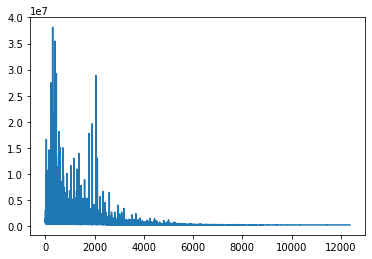

In [20]:
plt.plot(mean_field.hist);

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb0165add50>,
      dtype=object)

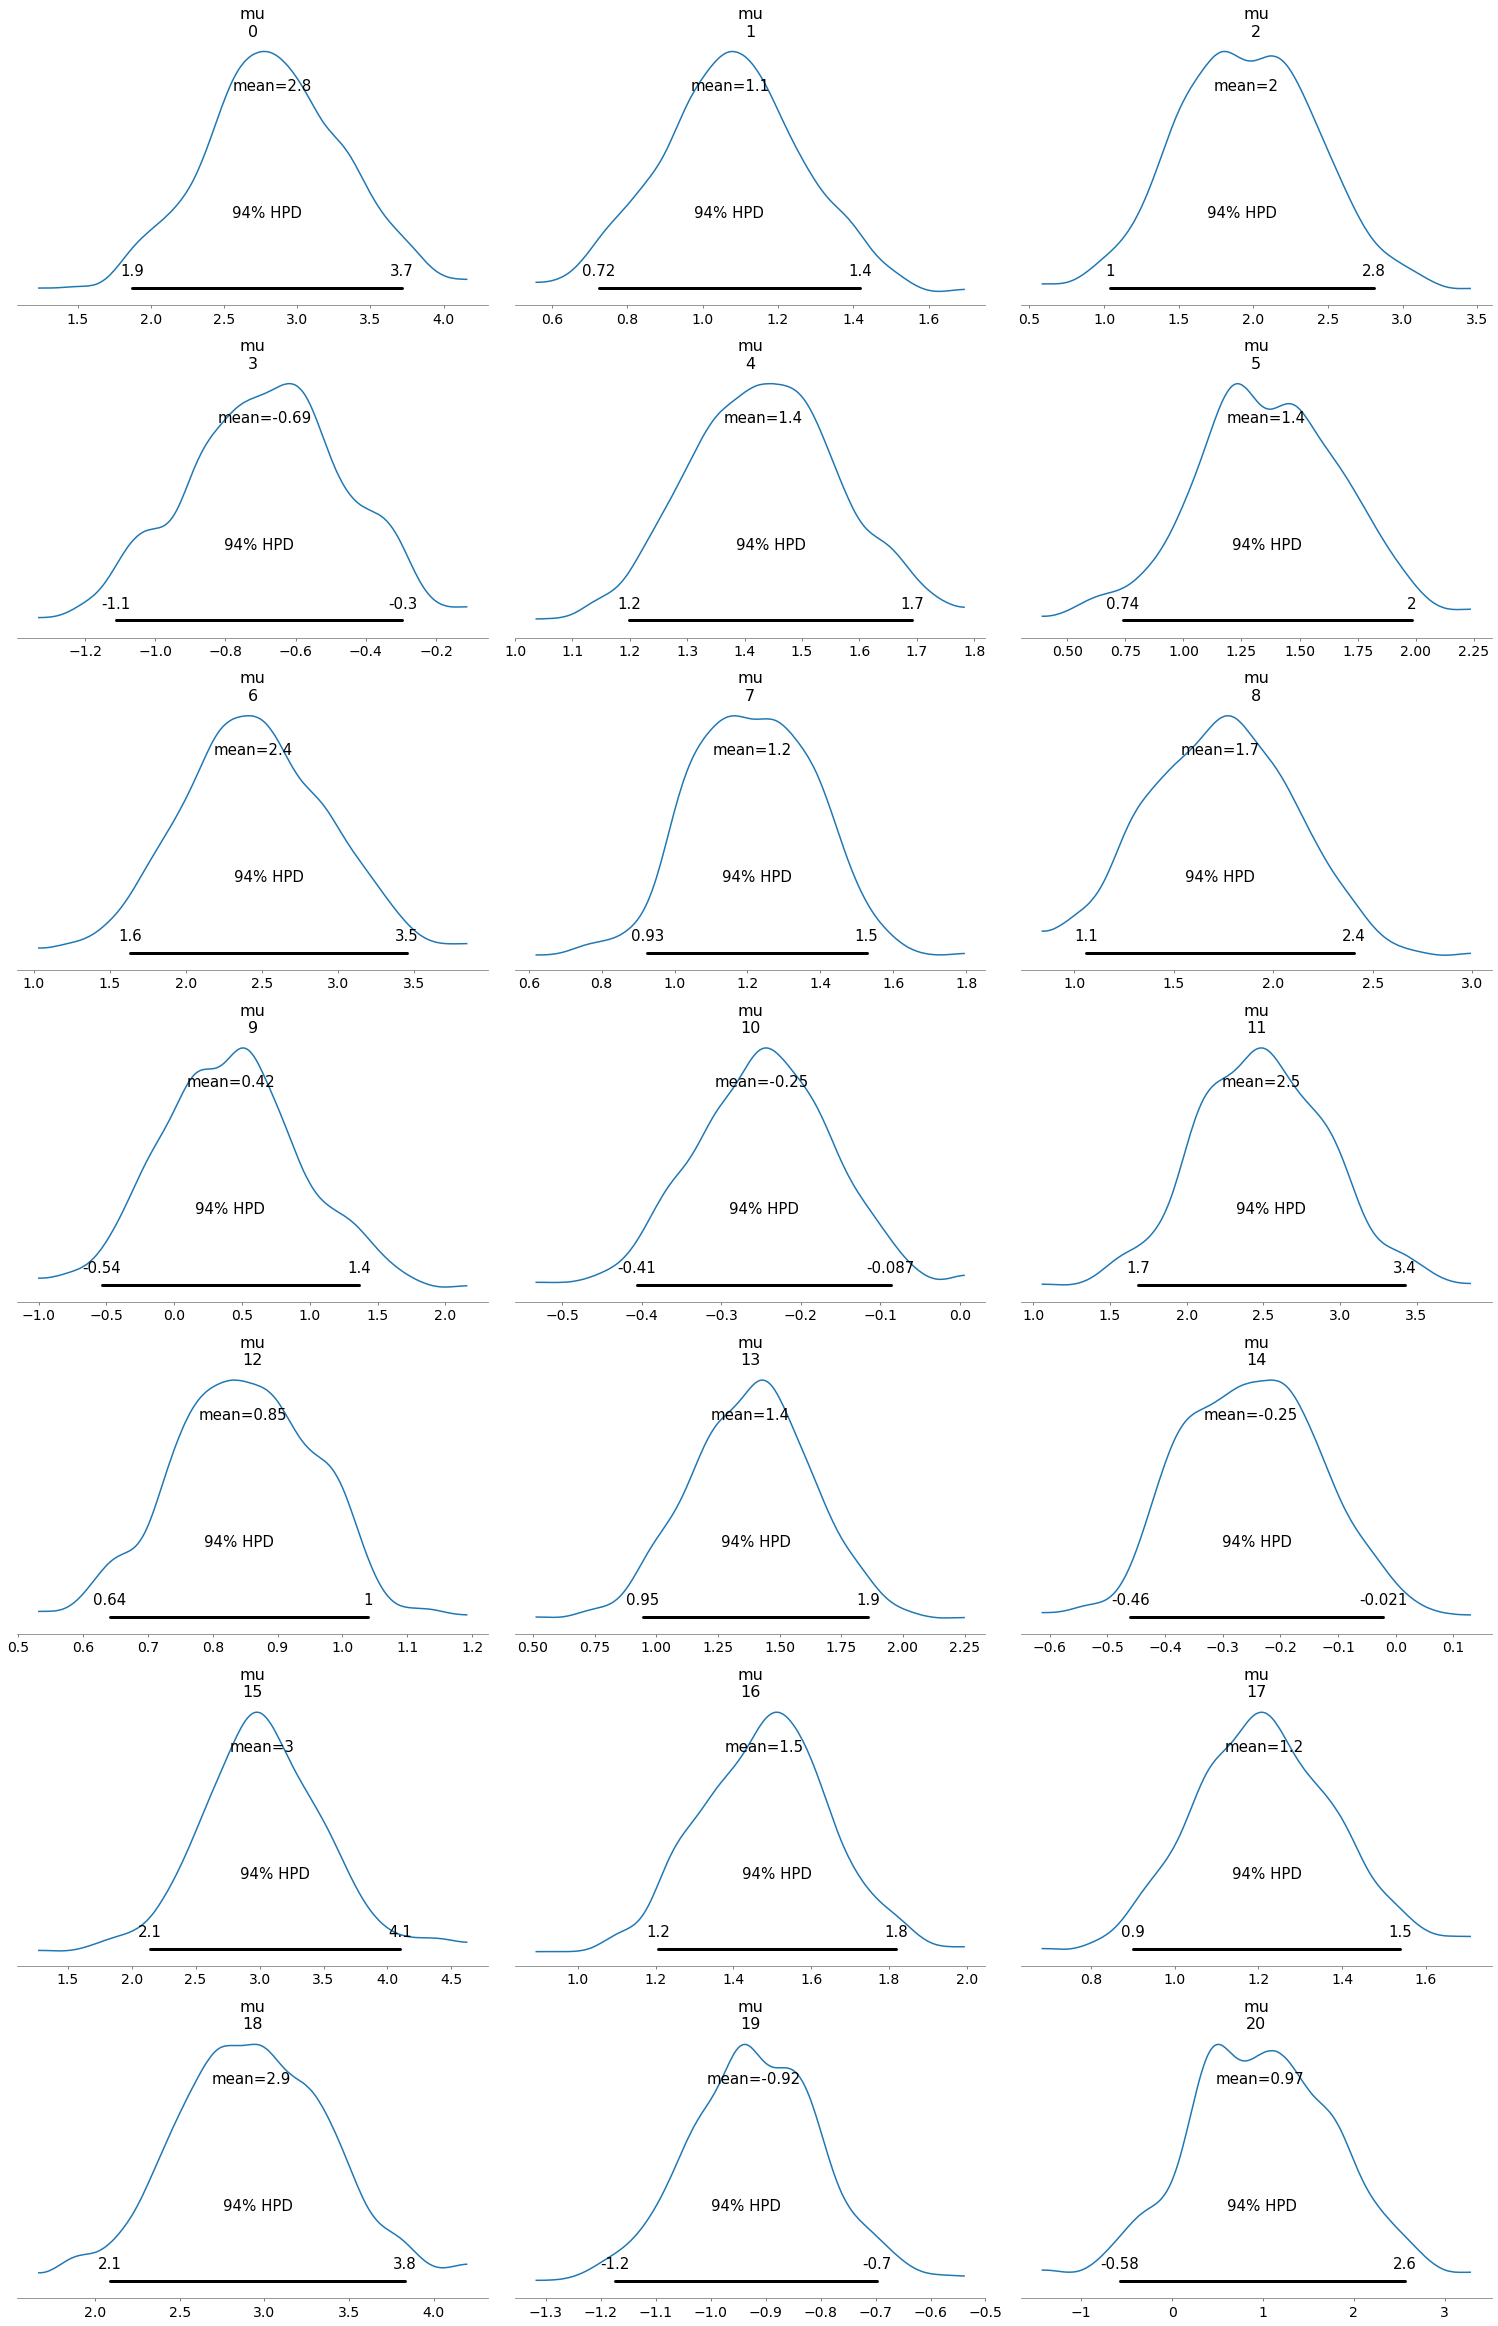

In [21]:
pm.plot_posterior(mean_field.sample(500), var_names='mu')

In [ ]:
osha_nz[osha_nz.industry_enc==0].log_conc.mean(), osha_nz[osha_nz.industry_enc==1].log_conc.mean(), osha_nz[osha_nz.industry_enc==3].log_conc.mean(), 

In [ ]:
osha_nz[osha_nz.industry_enc==0].head(1)['industry_name']

In [ ]:
pm.plot_posterior(mean_field.sample(500), var_names='sigma')

In [ ]:
osha_nz[osha_nz.industry_enc==0].log_conc.std(), osha_nz[osha_nz.industry_enc==1].log_conc.std(), osha_nz[osha_nz.industry_enc==3].log_conc.std(), 

### Hierarchical model including zeros

In [ ]:
log_conc = pm.Minibatch(osha['log_conc'].values, batch_size=1500)
conc = pm.Minibatch(osha['conc_mgm3'].values, batch_size=1500)
industry = pm.Minibatch(osha['industry_enc'].values, batch_size=1500)

In [ ]:
with pm.Model() as hierarchical_osha:
    
    global_mu = pm.Normal('global_mu', sd=2)
    prior_sigma = pm.Exponential('prior_sigma', lam=5.)
    mu = pm.Normal("mu", mu=global_mu, sd=prior_sigma, shape=(21,))
    
    prior_lam = pm.Exponential('prior_lam', lam=1.)
    sigma = pm.Exponential("sigma", lam=prior_lam, shape=(21,))
    
    like = pm.Normal(
        'likelihood',
        mu=mu[osha['sector_enc']],
        sd=sigma[osha['sector_enc']],
        observed=osha['log_conc'],
        #mu=mu[industry],
        #sd=sigma[industry],
        #observed=log_conc,
        total_size = len(osha)
    )
    
#with hierarchical_osha:
#    trace = pm.sample(2000,tune=2000)

In [ ]:
with hierarchical_osha:
    mean_field = pm.fit(50000, method='ADVI', callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])

In [ ]:
plt.plot(mean_field.hist);

In [ ]:
pm.plot_posterior(mean_field.sample(500), var_names='mu')

In [ ]:
osha[osha.industry_enc==15].log_conc.mean()

In [ ]:
osha[osha.industry_enc==16].log_conc.mean()

In [ ]:
len(osha[osha.industry_enc==15])

In [ ]:
mu, sigma = 9., 6 # mean and standard deviation
s = np.random.lognormal(mu, sigma, 1000)

#Display the histogram of the samples, along with the probability density function:
count, bins, ignored = plt.hist(s, 100, normed=True, align='mid')
x = np.linspace(min(bins), max(bins), 10000)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi)))

plt.plot(x, pdf, linewidth=2, color='r')
plt.axis('tight')
plt.show()



In [ ]:
pm.plot_posterior(mean_field.sample(500), var_names='sigma')

In [ ]:
osha[osha['sector_enc']==20].head(1)['sector_name']

In [ ]:
osha[osha['sector_enc']==11].head(1)['sector_name']

In [ ]:
osha[osha['sector_enc']==15].head(1)['sector_name']

### Non hierarchical model

In [ ]:
with pm.Model() as simple_osha:
    
    
    mu = pm.HalfNormal("mu", sd=10, shape=(21,))
    sigma = pm.HalfCauchy("sigma", beta=50, shape=(21,))
    
    like = pm.Normal(
        'likelihood',
        mu=mu[osha[sector_enc]],
        sd=sigma[osha[sector_enc]],
        observed=log_conc,
        total_size = len(osha)
    )
    
#with hierarchical_osha:
#    trace = pm.sample(2000,tune=2000)

In [ ]:
with simple_osha:
    mean_field = pm.fit(50000, method='ADVI', callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])

In [ ]:
pm.plot_posterior(mean_field.sample(500), var_names='mu')

In [ ]:
osha[osha.sector_enc==15].log_conc.mean()

In [ ]:
osha[osha.sector_enc==10].log_conc.mean()

## Three-level hierarchical model for non-zero observations

Drop data not defined to the subsector level

In [17]:
osha_nz_3 = osha_nz.dropna(subset=['subsector_name'])
osha_nz_3 = osha_nz_3.drop(osha_nz_3[osha_nz_3['subsector_name']=='Undefined/Multiple'].index)
osha_nz_3['sector_enc'] = osha_nz_3['sector_name'].astype('category').cat.codes  # re-factor
osha_nz_3['subsector_enc'] = osha_nz_3 ['subsector_name'].astype('category').cat.codes  # re-factor

In [18]:
len(osha_nz_3.sector_name.value_counts()), len(osha_nz_3.subsector_name.value_counts())

(20, 94)

In [19]:
sector = osha_nz_3['sector_enc'].values
subsector = osha_nz_3['subsector_enc'].values
log_conc = osha_nz_3['log_conc'].values

#sector_count = len(osha_nz_3.sector_name.value_counts())
#subsector_count = len(osha_nz_3.subsector_name.value_counts())

In [20]:
sector_index = osha_nz_3.groupby(['sector_name']).all().reset_index().reset_index()[['index', 'sector_name']]
sector_subsector_index = osha_nz_3.groupby(['sector_name', 'subsector_name']).all().reset_index().reset_index()[['index', 'sector_name', 'subsector_name']]
sector_subsector_indexes_df = pd.merge(sector_index, sector_subsector_index, how='inner', on='sector_name', suffixes=('_s', '_ss'))
indexed_osha_nz = pd.merge(osha_nz_3, sector_subsector_indexes_df, how = 'inner', on=['sector_name', 'subsector_name']).reset_index()

sector_indexes = sector_index['index'].values
sector_count = len(sector_indexes)
sector_subsector_indexes = sector_subsector_indexes_df['index_ss'].values
sector_subsector_count = len(sector_subsector_indexes)

In [21]:
sector_subsector_indexes_df

,index_s,sector_name,index_ss,subsector_name
0,0,Accomodation and Food Services,0,Accommodation
1,0,Accomodation and Food Services,1,Food Services and Drinking Places
2,1,Administrative and Support and Waste Managemen...,2,Administrative and Support Services
3,1,Administrative and Support and Waste Managemen...,3,Waste Management and Remediation Services
4,2,"Agriculture, Forestry, Fishing and Hunting",4,Animal Production and Aquaculture
...,...,...,...,...
89,17,Transportation and Warehousing,89,Water Transportation
90,18,Utilities,90,Utilities
91,19,Wholesale Trade,91,"Merchant Wholesalers, Durable Goods"
92,19,Wholesale Trade,92,"Merchant Wholesalers, Nondurable Goods"


In [22]:
indexed_osha_nz

,index,inspection_number,establishment_name,preferred_name,naics_unified,sector_name,subsector_name,industry_group_name,sector_enc,subsector_enc,industry_group_enc,conc_mgm3,log_conc,log_conc2,index_s,index_ss
0,0,29067,"GARMAT USA, INC.",Iron oxide,332322,Manufacturing,Fabricated Metal Product Manufacturing,Architectural and Structural Metals Manufacturing,10,26,18,1.959734,0.672860,0.672809,10,35
1,1,77128,"LINDGREN RF ENCLOSURES, INC.",Iron oxide,332321,Manufacturing,Fabricated Metal Product Manufacturing,Architectural and Structural Metals Manufacturing,10,26,18,0.290482,-1.235868,-1.236212,10,35
2,2,92153,"BARKER'S SANDBLASTING AND PAINTING, LLC",Iron oxide,332812,Manufacturing,Fabricated Metal Product Manufacturing,"Coating, Engraving, Heat Treating, and Allied ...",10,26,47,3.201927,1.163784,1.163753,10,35
3,3,92692,Morton Industries LLC,Iron oxide,332911,Manufacturing,Fabricated Metal Product Manufacturing,Other Fabricated Metal Product Manufacturing,10,26,185,5.025705,1.614586,1.614566,10,35
4,4,92827,"RP&G of Quincy, Inc.",Iron oxide,332119,Manufacturing,Fabricated Metal Product Manufacturing,Forging and Stamping,10,26,90,1.443526,0.367158,0.367089,10,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83776,83776,309289841,"WHITE'S GREENHOUSES, INC.",Mineral oil - includes paraffin oil,111421,"Agriculture, Forestry, Fishing and Hunting",Crop Production,"Greenhouse, Nursery, and Floriculture Production",2,20,106,0.797000,-0.226775,-0.226901,2,5
83777,83777,987614,"Taylor Farms Texas, Inc.",Ammonia,111219,"Agriculture, Forestry, Fishing and Hunting",Crop Production,Vegetable and Melon Farming,2,20,287,0.218702,-1.519586,-1.520043,2,5
83778,83778,"['315370106', 'SBFP-1']",STOKES BLUEBERRY FRESHPRO INC,Carbon monoxide,111334,"Agriculture, Forestry, Fishing and Hunting",Crop Production,Fruit and Tree Nut Farming,2,20,94,341.962577,5.834702,5.834701,2,5
83779,83779,"['315370106', 'SBFP-2']",STOKES BLUEBERRY FRESHPRO INC,Carbon monoxide,111334,"Agriculture, Forestry, Fishing and Hunting",Crop Production,Fruit and Tree Nut Farming,2,20,94,233.932188,5.455032,5.455031,2,5


In [23]:
with pm.Model() as hierarchical_3_osha:
    
    global_mu = pm.Normal('global_mu', sd=2)
    sector_sigma = pm.Exponential('prior_sigma2', lam=5.)
    
    sector_mu = pm.Normal("sector_mu", mu=global_mu, sd=sector_sigma, shape=sector_count)
    
    prior_sigma = pm.Exponential('prior_sigma', lam=5.)
    #y_hat2 = mu2[sector]
    
    subsector_mu = pm.Normal("subsector_mu", mu=sector_mu[sector_subsector_indexes_df['index_s']], sd=prior_sigma, shape=sector_subsector_count)
    
    prior_lam = pm.Exponential('prior_lam', lam=1.)
    sigma = pm.Exponential("sigma", lam=prior_lam, shape=sector_subsector_count)
    
    y_hat = subsector_mu[indexed_osha_nz['index_ss'].values]
    
    like = pm.Normal(
        'likelihood',
        mu=y_hat,
        sd=sigma[indexed_osha_nz['index_ss'].values],
        observed=indexed_osha_nz.log_conc.values
    )

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


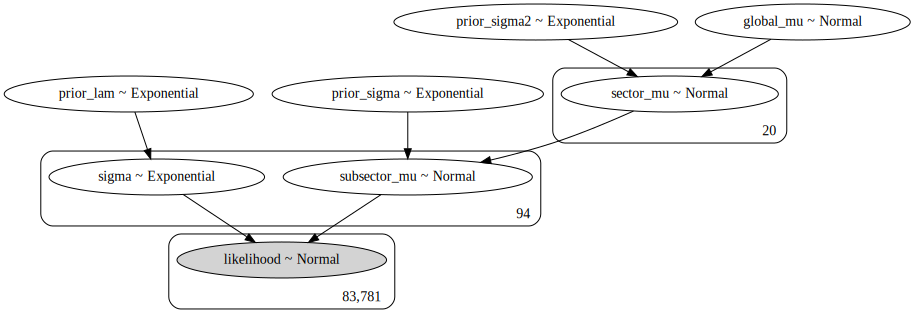

In [24]:
from pymc3 import model_to_graphviz

model_to_graphviz(hierarchical_3_osha)

In [ ]:
with hierarchical_3_osha:
    hmc = pm.sample(5000)

In [26]:
with hierarchical_3_osha:
    mean_field = pm.fit(20000, method='ADVI', callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])

  0%|          | 0/20000 [00:00<?, ?it/s]/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Average Loss = 2.3203e+05: 100%|██████████| 20000/20000 [02:06<00:00, 157.73it/s]
Finished [100%]: Average Loss = 2.3203e+05


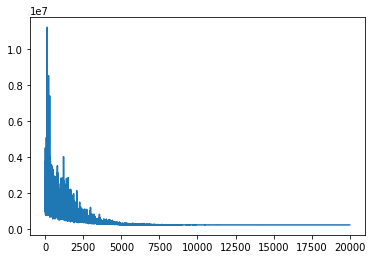

In [27]:
plt.plot(mean_field.hist);

<Figure size 432x1152 with 0 Axes>

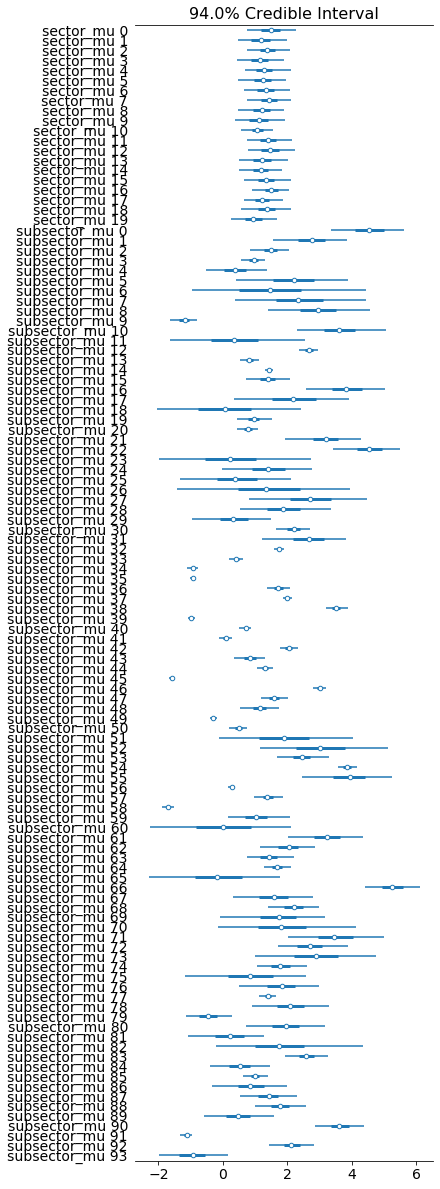

In [28]:
from pymc3 import forestplot
plt.figure(figsize=(6,16))
forestplot(mean_field.sample(1000), var_names=['sector_mu','subsector_mu']);

In [29]:
for i in range(94):
    mean = indexed_osha_nz[indexed_osha_nz['index_ss'] == i].log_conc.mean()
    print('Subsector {}: mu = {:.2}'.format(i,mean))

Subsector 0: mu = 5.5
Subsector 1: mu = 3.1
Subsector 2: mu = 1.5
Subsector 3: mu = 0.96
Subsector 4: mu = 0.29
Subsector 5: mu = 2.9
Subsector 6: mu = 8.9
Subsector 7: mu = 3.6
Subsector 8: mu = 3.8
Subsector 9: mu = -1.2
Subsector 10: mu = 4.5
Subsector 11: mu = -0.36
Subsector 12: mu = 2.7
Subsector 13: mu = 0.83
Subsector 14: mu = 1.4
Subsector 15: mu = 1.4
Subsector 16: mu = 4.6
Subsector 17: mu = 3.3
Subsector 18: mu = -2.2
Subsector 19: mu = 0.96
Subsector 20: mu = 0.78
Subsector 21: mu = 3.6
Subsector 22: mu = 5.2
Subsector 23: mu = -2.6
Subsector 24: mu = 1.6
Subsector 25: mu = 0.019
Subsector 26: mu = 7.5
Subsector 27: mu = 4.2
Subsector 28: mu = 2.2
Subsector 29: mu = 0.16
Subsector 30: mu = 2.2
Subsector 31: mu = 3.1
Subsector 32: mu = 1.7
Subsector 33: mu = 0.42
Subsector 34: mu = -0.94
Subsector 35: mu = -0.93
Subsector 36: mu = 1.7
Subsector 37: mu = 2.0
Subsector 38: mu = 3.5
Subsector 39: mu = -0.98
Subsector 40: mu = 0.71
Subsector 41: mu = 0.079
Subsector 42: mu = 2.

<Figure size 432x1152 with 0 Axes>

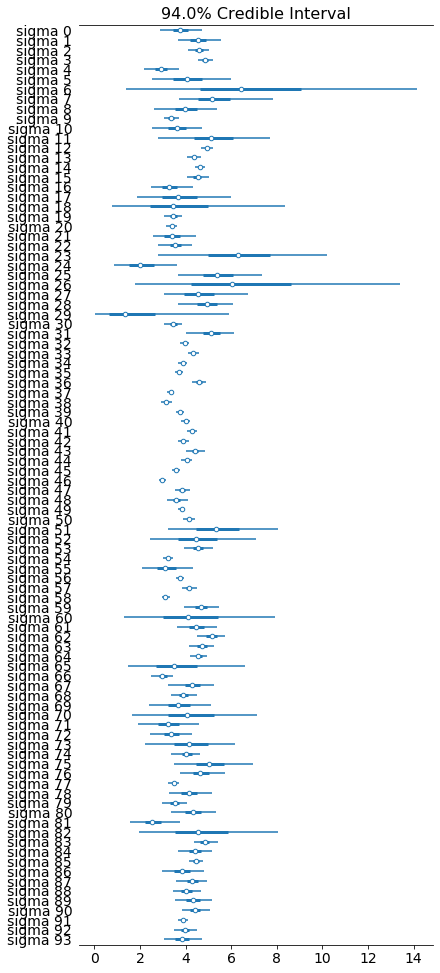

In [30]:
from pymc3 import forestplot
plt.figure(figsize=(6,16))
forestplot(mean_field.sample(1000), var_names=['sigma']);

In [32]:
pm.summary(mean_field.sample(500))

,mean,sd,mc_error,hpd_2.5,hpd_97.5
global_mu,1.248101,0.102002,0.004518,1.039341,1.425081
sector_mu__0,1.492024,0.399059,0.017768,0.794781,2.375507
sector_mu__1,1.182912,0.401476,0.019276,0.377527,1.951298
sector_mu__2,1.342850,0.383073,0.018019,0.639606,2.091409
sector_mu__3,1.092930,0.391195,0.017407,0.289530,1.845716
...,...,...,...,...,...
sigma__89,4.347344,0.467020,0.021747,3.494362,5.225988
sigma__90,4.410785,0.325747,0.014925,3.791512,5.120438
sigma__91,3.895972,0.108919,0.005204,3.694972,4.126784
sigma__92,3.993505,0.279380,0.012589,3.430918,4.499172


In [54]:
# this generates 500 sets of predictions of the osha dataset values (n=83.7k)
ppc = pm.sample_posterior_predictive(mean_field.sample(1000), samples= 500, model=hierarchical_3_osha)

100%|██████████| 500/500 [00:05<00:00, 90.86it/s]
